IMPORTATION DES BIBLIOTHEQUES PYTHON

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

LECTURE DES IMAGES DU DOSSIER

In [15]:
dossier = './datasetchiencourt' #racine de notre dataset
donnee = [] #donnee pour chaque image
race = [] #race qui correspond a chaque image récupéré

SIZE = 128 #Taille de nos image
NBDOSSIER=12 #Nombre de dossier de notre dataset (pour ensuite diviser en catégorie)

for folder in os.listdir(dossier): #on parcour notre dossier
    for file in os.listdir(os.path.join(dossier, folder)):
        if file.endswith("jpg"): #si le fichier est de type .jpg
            race.append(folder) #on ajoute le nom du dossier, soit la race
            img = cv2.imread(os.path.join(dossier, folder, file)) #on lit l'image récupéré
            img_resize = cv2.resize(img, (SIZE,SIZE)) #on redéfinit une taille standard pour chaque image
            race.append(img_resize) #on ajoute l'image
        else:
            continue

CONVERTION DES DONNEES

In [4]:
donnee_liste = np.array(donnee) #donnée sont stockes dans une liste
race_liste = np.array(race) #idem pour les races
#Attention race_liste contient plusieurs mêmes races, on a par exemple 50 fois labrador car notre dataset comportait 50 images de labrador dans le dossier labrador
#Il est plus simple de convertir nos donnee sous forme de liste pour pouvoir mieux les manipuler par la suite

NORMALISATION DES DONNEES

In [5]:
encoder = LabelEncoder()
y = encoder.fit_transform(race_liste)
y = to_categorical(y,NBDOSSIER)
X = donnee_liste/255 ##couleur

DIVISION DES DONNEES

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
#on sépare notre databse en 2 partie : une partie entrainement de 80% et une partie de test de 20%

CREATION DU MODELE (au choix)

    Modèle séquentiel

In [8]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (SIZE,SIZE,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Couche de classification
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
#éviter overfiting --> éviter qu'il est trop de chose à prendre
model.add(Dense(NBDOSSIER, activation = "softmax"))


CREATION D'IMAGE D'ENTRAINEMENT

In [9]:
#Avant de compiler notre modèle, on crée plus d'images d'entrainement pour éviter l'overfitting
#Overfitting est le fait de sur-apprendre quelques chose
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range = 0.20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)



COMPILATION DU MODELE


In [10]:
nb_images=32 #nombre images qu'il va prendre par tour d'entrainement
epochs=1 #nombre de tours d'entrainement


    Modèle séquentiel / par catégorie

In [25]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=nb_images),
                              epochs = epochs,
                              validation_data = (X_test,y_test),
                              verbose = 1)

TypeError: fit_generator() got multiple values for argument 'epochs'

    Modèle séquentiel / binaire

In [20]:
model.compile(optimizer =Adam(learning_rate=0.0001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history2 = model.fit_generator(datagen.flow(X_train,y_train, batch_size=nb_images),
                              epochs = epochs,
                              validation_data = (X_test,y_test),
                              verbose = 1)

57/57 [==============================] - 87s 2s/step - loss: 0.5670 - accuracy: 0.0942 - val_loss: 0.3741 - val_accuracy: 0.1344

SAUVEGARDE DU MODELE

In [16]:
model.save("model.h5")

PHASE DE TEST

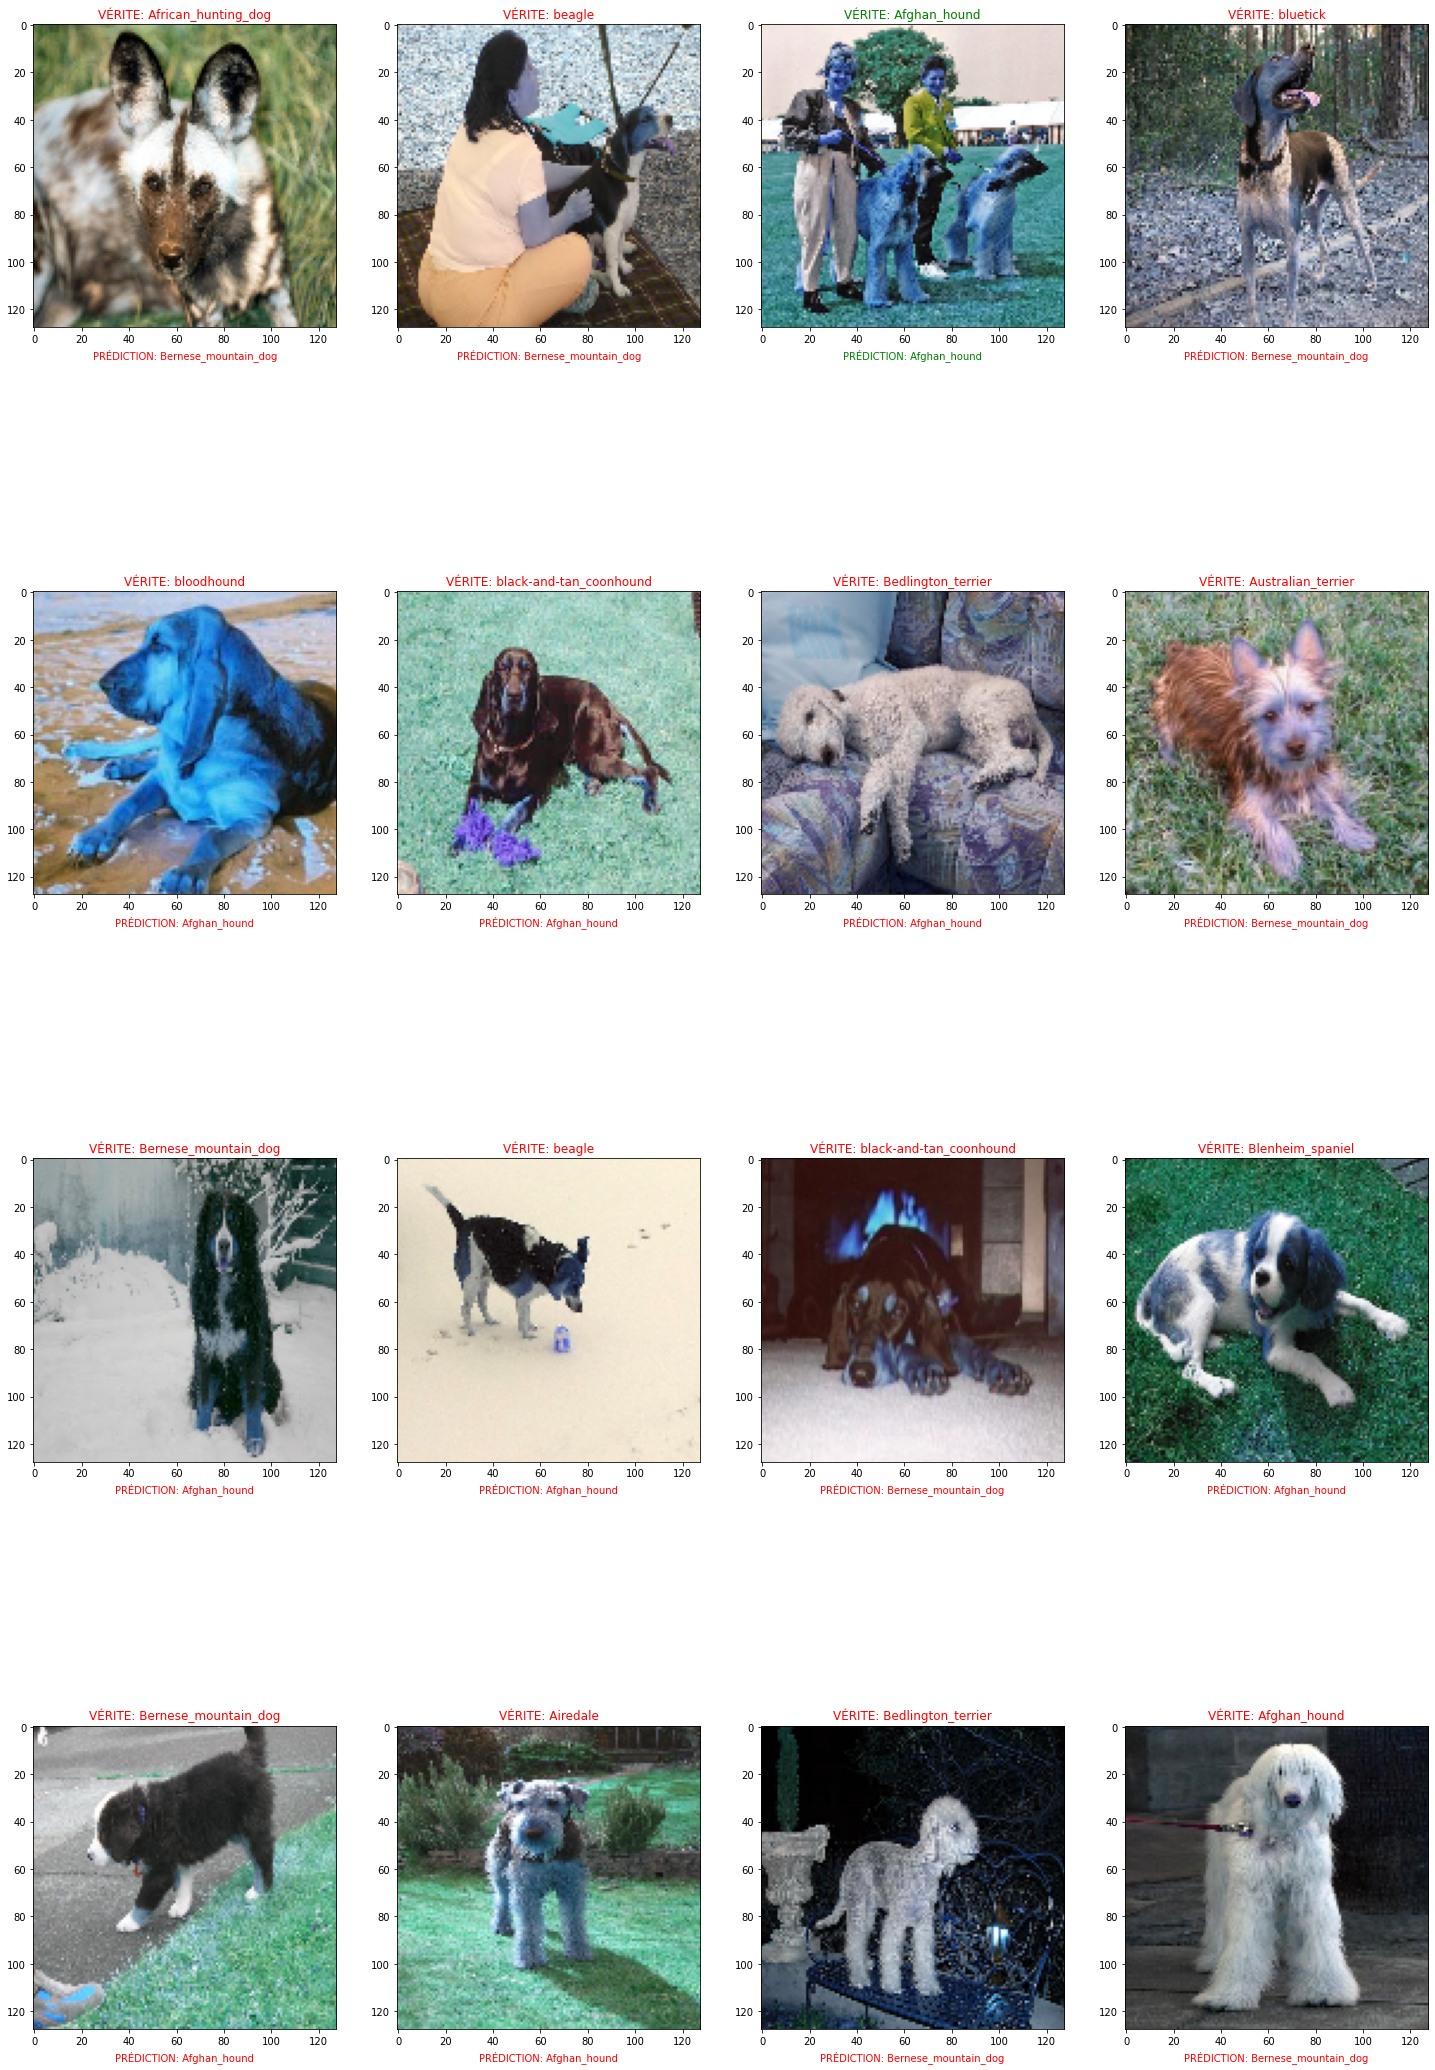

In [16]:
#On teste si le modèle reconnait les données
TAILLETEST=4
races = np.sort(os.listdir(dossier))
fig, ax = plt.subplots(TAILLETEST,TAILLETEST, figsize=(25, 40))

for i in range(TAILLETEST):
    for j in range(TAILLETEST):
        k = int(np.random.random_sample() * len(X_test))
        #si la prédiction est égale à la vérité
        if(races[np.argmax(y_test[k])] == races[np.argmax(model.predict(X_test)[k])]):
            ax[i,j].set_title("VÉRITE: " + races[np.argmax(y_test[k])], color='green')
            ax[i,j].set_xlabel("PRÉDICTION: " + races[np.argmax(model.predict(X_test)[k])], color='green')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3))
        #sinon c'est que la prédiction est fausse
        else:
            ax[i,j].set_title("VÉRITE: " + races[np.argmax(y_test[k])], color='red')
            ax[i,j].set_xlabel("PRÉDICTION: " + races[np.argmax(model.predict(X_test)[k])], color='red')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3))